In [241]:
import numpy as np
import torch
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from automatic_car.utils import train
from automatic_car.utils import test
from automatic_car.frame_dataset import FramesDataset
from automatic_car.models import Model1
from automatic_car.models import Model2
import torchmetrics
import pandas as pd
from IPython.display import display, HTML

In [42]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 5


In [43]:
train_dataset = FramesDataset("train")
train_dataloader = DataLoader(train_dataset,batch_size= 32,shuffle = True)
test_dataset = FramesDataset("test")
test_dataloader = DataLoader(test_dataset,batch_size= 32,shuffle = True)

# Dataset evaluation

Even though the deep learning field is getting more and more mature each day there still isn't a correct approach for the determination of a good model.
I don't have at my disposal the computational power of testing different models and different parameters so the analysis will be more focused onthe results.
We have a car in a simulated environment.
The objective is to solve an image classification problem to learn the behaviour of a racing car in a Gym environment.

![Example of a run](./media/full_frame.gif)

The first thing that I notices when fiddling with the environment was using a twchnique called [parallax scrolling](https://en.wikipedia.org/wiki/Parallax_scrolling#:~:text=Parallax%20scrolling%20is%20a%20technique,traditional%20animation%20since%20the%201930s.) which means essentially that the car is a still frame.
This means that using data augmentation would not be useful.
In general data augmentation is used in context where a single pixel shift doesn't change the portraied subject, i.e a cat shifter of $N$ pixels should still be detected as a cat.
So the result was to use the raw dataset.
This however poses a problem, because the dataset is not balanced.

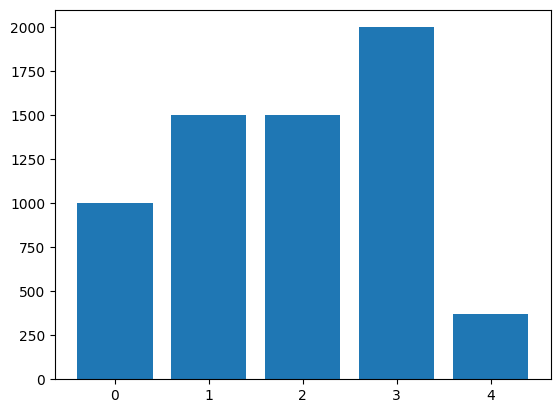

In [44]:
examples_dict = train_dataset.get_examples_per_class()
plt.bar(range(len(examples_dict)), list(examples_dict.values()), align='center')
plt.xticks(range(len(examples_dict)), list(str(k) for k in examples_dict.keys()))
plt.show()

# Models evaluation

The first thing that I would control is the accuracy.
Accuracy computes the fraction of predictions our model got right.
The problem is that when the dataset is umbalanced, it doesn't tell us the fulls story.
So the very first thing we could do is get a sense of what loss we have.
Pytorch is rather modular when it comes to create and train a neural network and in particular I've got full control over the optimizer and the loss.

In particular I choose as a loss the CrossEntropy loss, because we've got the ability to assign a weight to each class, depending on the number of examples per class.

As an optimizer I used stochastig gradient descent because is basic enough and usually is a good choice.
After 80 epochs here's the result.

In [51]:
num_channels = train_dataset.get_num_channels()
num_classes = train_dataset.get_num_classes()
model1 = Model1(num_channels=num_channels,num_classes=num_classes)

if model1.exists():
    torch.load(f= model1.path)
    
else:
    loss_fn = nn.CrossEntropyLoss(weight= train_dataset.get_weights())
    optimizer = SGD(model1.parameters(),lr = 0.001)
    train_loss = []
    test_loss = []
    for _ in range(EPOCHS):
        train_loss.append(train(model=model1,data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,device=DEVICE))
        test_loss.append(test(model=model1,data_loader=test_dataloader,loss_fn=loss_fn,device=DEVICE))
    torch.save(obj = model1.state_dict(),f = model1.path )

    plt.plot(train_loss,label='Train loss')
    plt.plot(test_loss,label='Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Values')
    loss_min = np.round(np.min([train_loss,test_loss])).astype(int)
    loss_max = np.round(np.max([train_loss,test_loss])).astype(int)
    plt.xticks(np.arange(0,EPOCHS,step=EPOCHS /10))
    plt.yticks(np.arange(0,loss_max, step= (loss_max-loss_min)/10))

    plt.legend()
    plt.savefig(model1.info("loss_graph.png"), bbox_inches='tight')
    

In [50]:
num_channels = train_dataset.get_num_channels()
num_classes = train_dataset.get_num_classes()
model2 = Model2(num_channels=num_channels,num_classes=num_classes)
if model2.exists():
    torch.load(f= model2.path)
else:
    loss_fn = nn.CrossEntropyLoss(weight= train_dataset.get_weights())
    optimizer = SGD(model2.parameters(),lr = 0.001)
    train_loss = []
    test_loss = []
    for _ in range(EPOCHS):
        train_loss.append(train(model=model2,data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,device=DEVICE))
        test_loss.append(test(model=model2,data_loader=test_dataloader,loss_fn=loss_fn,device=DEVICE))
    torch.save(obj = model2.state_dict(),f = model2.path )

    plt.plot(train_loss,label='Train loss')
    plt.plot(test_loss,label='Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Values')
    loss_min = np.round(np.min([train_loss,test_loss])).astype(int)
    loss_max = np.round(np.max([train_loss,test_loss])).astype(int)
    plt.xticks(np.arange(0,EPOCHS,step=EPOCHS /10))
    plt.yticks(np.arange(0,loss_max, step= (loss_max-loss_min)/10))
    plt.legend()
    plt.savefig(model2.info("loss_graph.png"), bbox_inches='tight')

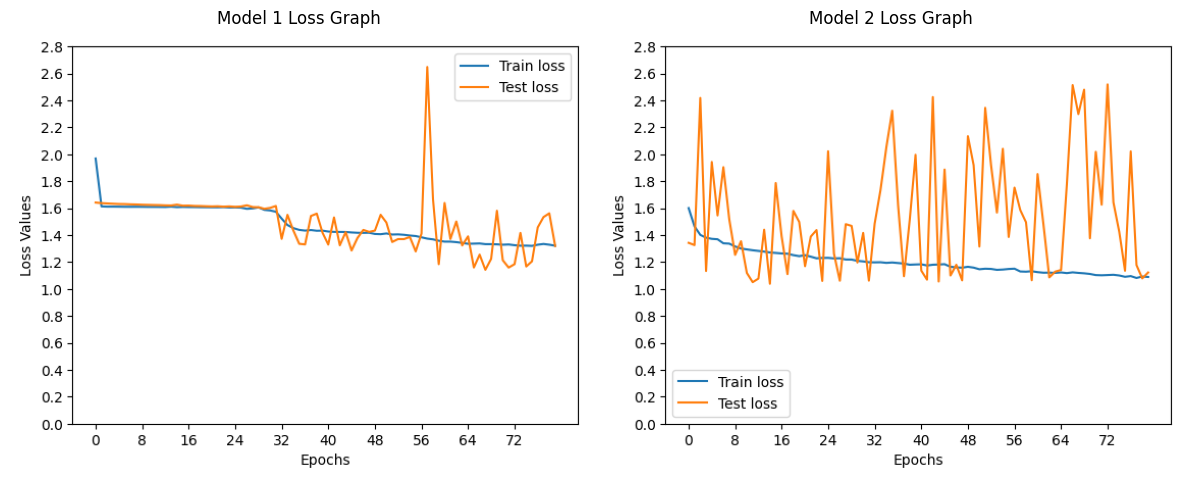

In [209]:
model_1_loss_graph = plt.imread(model1.info("loss_graph_80.png"))
model_2_loss_graph = plt.imread(model2.info("loss_graph_80.png"))


fig, axes = plt.subplots(1, 2,figsize=(12, 6))

# Display the first image on the left subplot
axes[0].imshow(model_1_loss_graph)
axes[0].set_title('Model 1 Loss Graph')  # Set title if desired

# Display the second image on the right subplot
axes[1].imshow(model_2_loss_graph)
axes[1].set_title('Model 2 Loss Graph')  # Set title if desired

# Hide axis ticks and labels
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

We can see there's a big fluctuation in the test loss, in particular in the second model which is bigger.
I think that this is due to the fact that the dataset is pretty small compared to normal deep learning datasets, and in conjuction with it being fairly large causing overfitting.

What I applied was a cenique called early stopping, looking at the graph at around 5 epochs I should be good to go.

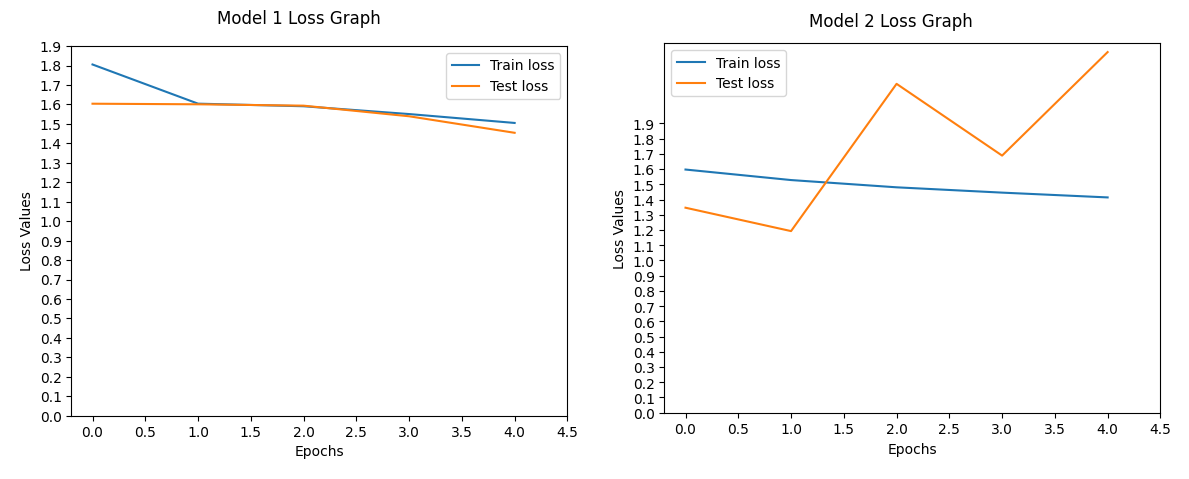

In [196]:
model_1_loss_graph = plt.imread(model1.info("loss_graph.png"))
model_2_loss_graph = plt.imread(model2.info("loss_graph.png"))


fig, axes = plt.subplots(1, 2,figsize=(12, 6))

# Display the first image on the left subplot
axes[0].imshow(model_1_loss_graph)
axes[0].set_title('Model 1 Loss Graph')  # Set title if desired

# Display the second image on the right subplot
axes[1].imshow(model_2_loss_graph)
axes[1].set_title('Model 2 Loss Graph')  # Set title if desired

# Hide axis ticks and labels
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

Even though we stabilized the training loss for model 1 we still need a way to quantify it's performance.
At first let's take a glance at the accuracy.

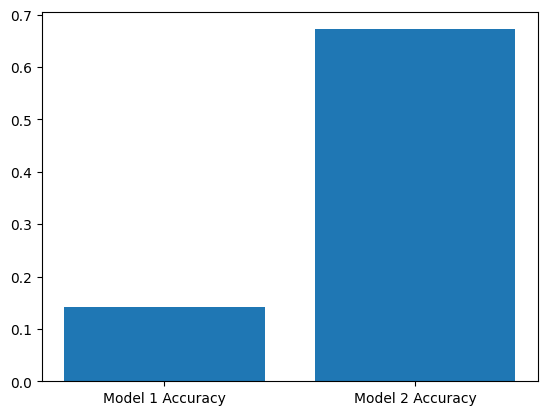

In [208]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12, 9))
accuracy1 = torchmetrics.Accuracy(task = "multiclass",num_classes=num_classes)
accuracy2 = torchmetrics.Accuracy(task = "multiclass",num_classes=num_classes)



model1.eval()
softmax = nn.Softmax(dim = 1)
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model1(X)
        preds = np.argmax(softmax(test_pred),axis =1)
        accuracy1.update(preds,y)
model2.eval()
softmax = nn.Softmax(dim = 1)
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model2(X)
        preds = np.argmax(softmax(test_pred),axis =1)
        accuracy2.update(preds,y)
values = [accuracy1.compute(),accuracy2.compute()]

plt.bar(["Model 1 Accuracy","Model 2 Accuracy"],values)
print()

As far as accuracy is concerned It seems that the model 2 is far better than model 1, but this is in contrast with what we would've expected from the models losss progression.
Let's see why this is the case.
From the introduction we already mentioned that the training dataset is very imbalanced, but this get's even more noticeable in the training dataset.

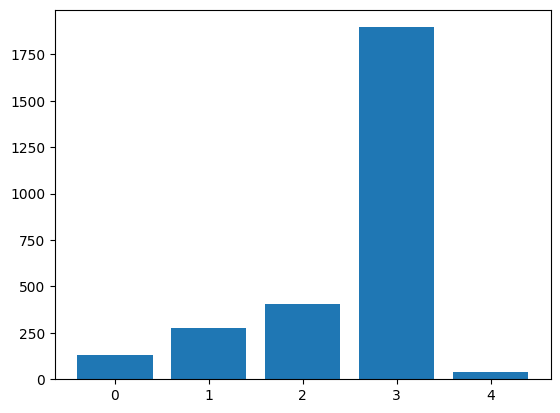

In [217]:
tests_dict = test_dataset.get_examples_per_class()
plt.bar(range(len(tests_dict)), list(tests_dict.values()), align='center')
plt.xticks(range(len(tests_dict)), list(str(k) for k in tests_dict.keys()))
plt.show()

To get a better grasp of the numbers here's the percentage of elements divided by class.

In [245]:
n_tests = np.array(list(test_dataset.get_examples_per_class().values()))
n_tests = np.round(n_tests/n_tests.sum()*100,2)
data = {f"% of elements of Class {i}":v for i,v in enumerate(n_tests)}
df = pd.DataFrame([data])

display(HTML(df.to_html(index=False)))


% of elements of Class 0,% of elements of Class 1,% of elements of Class 2,% of elements of Class 3,% of elements of Class 4
4.84,10.0,14.77,68.97,1.42


That nearly $70%$ of accuracy in the class 3 seems suspicious.
What I'm referring to is that a possibvle explanation of what we're witnessing is:
In general model1 is a very basic CNN, given it's accuracy it may be possible that it is just a random guesser i.e ransomly picks a class out of the 5 hence 20% accuracy.
On the other hand model2 is fairly deep and complicated, meaning that there are a lot more parameters involved and in general a higher complexity, this means that probably the model is overfitting, to a point that in order to increase the rate of accurate predictions it just simply spit out class 3.
to make it more concrete, given 100 examples if we always predict 3 we would get around  70% accuracy since we will be misclassifying only rhe remaining classes that contitute a mere 30%
It is a well known fact that accuracy is not a good measurement for imbalanced datasets, but this was only a demostration of that.


When dealing with unbalanced dataset the preferred metrics are precision and recall.
While precision is the ability to avoid false positives, recall is the ability to avoid false negatives.
A good model would ideally have both values high, but in general there is a trade-off between precision and recall.
So one must be choosen over the other, but this decision is application dependant.
In this case we have no idea on which is better to minimize, so I decided to opt for another metric call F1score.
In poarticular we're going to calulate the F1 score with macro averaging, meaning that we're leaving behind the number of support.
This is becasue using the micro averave we're calculating  essentially the accuracy, while using the weighted we would be given too much importance to the classes with too many examples, in this case class 3.

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 9))
# precision1 = torchmetrics.Precision(task = "multiclass",num_classes=num_classes,average= None)
# precision2 = torchmetrics.Precision(task = "multiclass",num_classes=num_classes,average= None)

# model1.eval()
# softmax = nn.Softmax(dim = 1)
# with torch.inference_mode():
#     for X, y in test_dataloader:
#         test_pred = model1(X)
#         preds = np.argmax(softmax(test_pred),axis =1)
#         precision1.update(preds,y)
# model2.eval()
# softmax = nn.Softmax(dim = 1)
# with torch.inference_mode():
#     for X, y in test_dataloader:
#         test_pred = model2(X)
#         preds = np.argmax(softmax(test_pred),axis =1)
#         precision2.update(preds,y)
# precision1.plot(ax=ax[0])
# ax[0].set_title('Model 1 Precision Graph')
# precision2.plot(ax=ax[1])
# ax[1].set_title('Model 2 Precision Graph')
# print()

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 9))
# precision1 = torchmetrics.Recall(task = "multiclass",num_classes=num_classes,average= None)
# precision2 = torchmetrics.Recall(task = "multiclass",num_classes=num_classes,average= None)

# model1.eval()
# softmax = nn.Softmax(dim = 1)
# with torch.inference_mode():
#     for X, y in test_dataloader:
#         test_pred = model1(X)
#         preds = np.argmax(softmax(test_pred),axis =1)
#         precision1.update(preds,y)
# model2.eval()
# softmax = nn.Softmax(dim = 1)
# with torch.inference_mode():
#     for X, y in test_dataloader:
#         test_pred = model2(X)
#         preds = np.argmax(softmax(test_pred),axis =1)
#         precision2.update(preds,y)
# precision1.plot(ax=ax[0])
# ax[0].set_title('Model 1 Recall Graph')
# precision2.plot(ax=ax[1])
# ax[1].set_title('Model 2 Recall Graph')
# print()


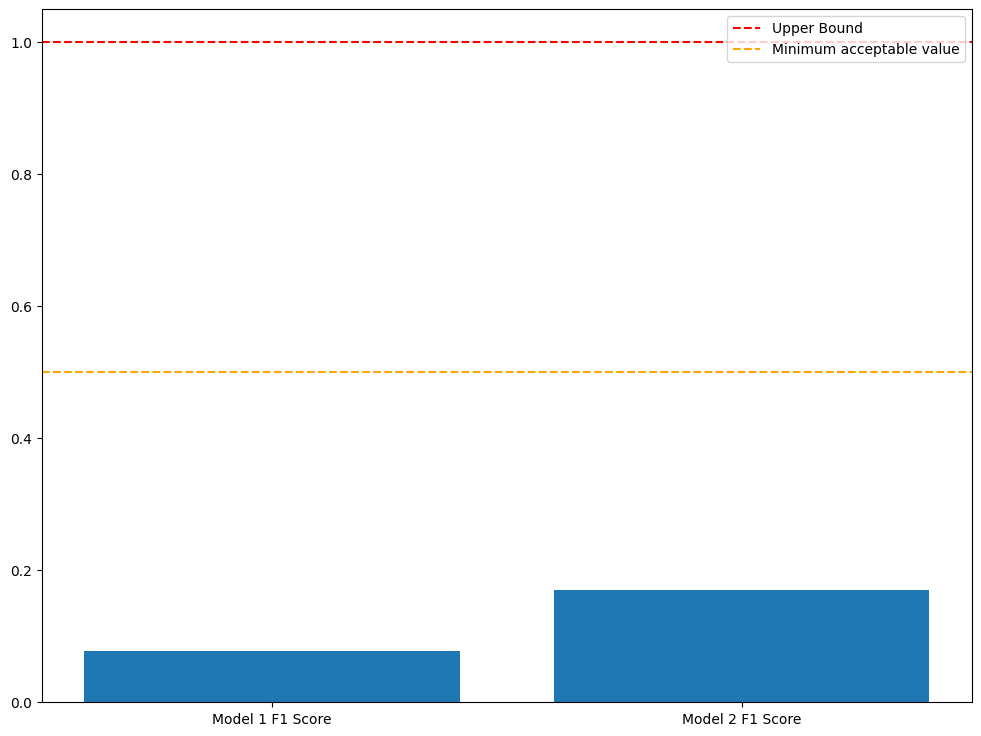

In [253]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12, 9))
f1score1 = torchmetrics.F1Score(task = "multiclass",num_classes=num_classes,average='macro')
f1score2 = torchmetrics.F1Score(task = "multiclass",num_classes=num_classes,average='macro')



model1.eval()
softmax = nn.Softmax(dim = 1)
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model1(X)
        preds = np.argmax(softmax(test_pred),axis =1)
        f1score1.update(preds,y)
model2.eval()
softmax = nn.Softmax(dim = 1)
with torch.inference_mode():
    for X, y in test_dataloader:
        test_pred = model2(X)
        preds = np.argmax(softmax(test_pred),axis =1)
        f1score2.update(preds,y)
values = [f1score1.compute(),f1score2.compute()]

ax.bar(["Model 1 F1 Score","Model 2 F1 Score"],values)
ax.axhline(y=1, color='red', linestyle='--', label='Upper Bound')
ax.axhline(y=.5, color='orange', linestyle='--', label='Minimum acceptable value')
plt.legend()
print()

As we can see form the histogram we're not even close to a minimum acceptable F1 score, let alone be a good one.
This is coherent to what we've said before, these models are not good at all.
But why is that?
One of the first reasons the dataset is very small for a deep learning model, so it's easy to overshoot complexity and overfit.
This is particularly evident  in the model2.
Also the photos are visually all very much similar, for example here's three photos taken from the training dataset from class 0,1,3.

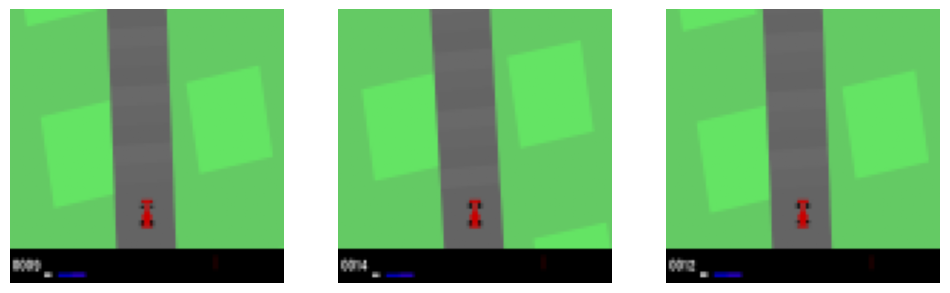

In [294]:
img1 = plt.imread("data/test/3/0040.png")
img2 = plt.imread("data/test/0/0048.png")
img3 = plt.imread("data/test/2/0003.png")
ig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12, 6))
ax[0].imshow(img1)
ax[0].axis("off")
ax[1].imshow(img2)
ax[1].axis("off")
ax[2].imshow(img3)
ax[2].axis("off")
print()

I'm not able to distinguish which is which (the first one is "data/test/3/0040.png", the second one is "data/test/0/0048.png",and the third one is "data/test/2/0003.png") so I suppose is expected that this models fails independtently on how much we train them or specialize them.
The thing is, probably the dataset is not fit for the task.
Let me explain:
When I introduced the contect I put a gif example on how the environment works, but if we focus on the lower part.

![cropped_frame](media/cropped_frame.gif)

We can see that the bar has movements associated with the state of the previous action, so the knowledge of the next best action is surely dependent on the frame, but is also dependent on the previous frame.
To make things more concrete there are three levels of accelleration, if you deceleate the level of acceleration turns one level down, so is easy to see that no matter what the next action is, breaking is not an option if we're still, we cannot go neither right or left if we're still and doing nothing takes away points, so the only conceivable option is gassing.
This explain two things, the first is that the great prevalence of class 3, examples, gassing is due to the fact that most of the time gassing is the only concrete choiche.
Another information is that we need the information provided by the bar.
However this information is lost due to the fact that the images are small and retriving informations from the lower bar is very difficult since it occupies a relatively small portion of the frame.
In my spare time I tried to train a model for this but with no avail.

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 9))
# precision1 = torchmetrics.ConfusionMatrix(task = "multiclass",num_classes=num_classes)
# precision2 = torchmetrics.ConfusionMatrix(task = "multiclass",num_classes=num_classes)

# model1.eval()
# softmax = nn.Softmax(dim = 1)
# with torch.inference_mode():
#     for X, y in test_dataloader:
#         test_pred = model1(X)
#         preds = np.argmax(softmax(test_pred),axis =1)
#         precision1.update(preds,y)
# model2.eval()
# softmax = nn.Softmax(dim = 1)
# with torch.inference_mode():
#     for X, y in test_dataloader:
#         test_pred = model2(X)
#         preds = np.argmax(softmax(test_pred),axis =1)
#         precision2.update(preds,y)
# precision1.plot(ax=ax[0])
# ax[0].set_title('Model 1 Confusion matrix')
# precision2.plot(ax=ax[1])
# ax[1].set_title('Model 2 Confusion matrix')
# print()

In [194]:
img,true_label = test_dataset[800]
print(img.shape)
img = img.unsqueeze(0)
print(img.shape)
model1.eval()
softmax = nn.Softmax(dim =0)
with torch.inference_mode():
    print(np.argmax(softmax(model1(img))).item(),true_label)


torch.Size([3, 96, 96])
torch.Size([1, 3, 96, 96])
0 2


THERE are three levels of acceleration 

In [195]:
# torch.manual_seed(35)
# softmax = nn.Softmax(dim = 1)
# with torch.inference_mode():
#     for X, y in train_dataloader:
#         X, y = X.to(DEVICE), y.to(DEVICE)
#         test_pred = model(X)
#         # print(test_pred.shape)
#         print(softmax(test_pred)[0])
#         break

# Resources:

- [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- [](https://forums.fast.ai/t/very-volatile-validation-loss/7573/9)
- https://towardsdatascience.com/softmax-and-uncertainty-c8450ea7e064
- https://stephenallwright.com/interpret-f1-score/
- https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#:~:text=(3)-,Macro%20Average,-Macro%20averaging%20is
- https://stephenallwright.com/interpret-f1-score/